## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout, BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 16 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.1]
redice_lr_patient = [8, 12]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 8
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Train on 50000 samples, validate on 10000 samples
Epoch 1/16
50000/50000 [==============================] - 7s 140us/step - loss: 2.2644 - accuracy: 0.2584 - val_loss: 2.1648 - val_accuracy: 0.2028
Epoch 2/16
50000/50000 [==============================] - 5s 97us/step - loss: 1.7684 - accuracy: 0.3827 - val_loss: 1.9849 - val_accuracy: 0.2845
Epoch 3/16
50000/50000 [==============================] - 5s 95us/step - loss: 1.6359 - accuracy: 0.4267 - val_loss: 1.8435 - val_accuracy: 0.3541
Epoch 4/16
50000/50000 [==============================] - 5s 94us/step - loss: 1.5619 - accuracy: 0.4551 - val_loss: 1.7239 - val_accuracy: 0.3967
Epoch 5/16
50000/50000 [==============================] - 5s 95us/step - loss: 1.5069 - accuracy: 0.4710 - val_loss: 1.6332 - val_accuracy: 0.4319
Epoch 6/16
50000/50000 [==============================] - 5s 96us/step - loss: 1.4627 - accuracy: 0.4894 - val_loss: 1.5799 - val_accuracy: 0.4497
Epoch 7/16
50000/50000 [==============================] - 5s 94us/s

50000/50000 [==============================] - 5s 100us/step - loss: 1.3588 - accuracy: 0.5222 - val_loss: 1.8339 - val_accuracy: 0.3463
Epoch 4/16
50000/50000 [==============================] - 5s 98us/step - loss: 1.2747 - accuracy: 0.5519 - val_loss: 1.8680 - val_accuracy: 0.3622
Epoch 5/16
50000/50000 [==============================] - 5s 99us/step - loss: 1.2034 - accuracy: 0.5772 - val_loss: 1.5167 - val_accuracy: 0.4640
Epoch 6/16
50000/50000 [==============================] - 5s 98us/step - loss: 1.1429 - accuracy: 0.5968 - val_loss: 1.6979 - val_accuracy: 0.3970
Epoch 7/16
50000/50000 [==============================] - 5s 97us/step - loss: 1.0967 - accuracy: 0.6133 - val_loss: 1.6094 - val_accuracy: 0.4449
Epoch 8/16
50000/50000 [==============================] - 5s 103us/step - loss: 1.0409 - accuracy: 0.6340 - val_loss: 1.8399 - val_accuracy: 0.3885
Epoch 9/16
50000/50000 [==============================] - 5s 97us/step - loss: 0.9986 - accuracy: 0.6506 - val_loss: 1.8830 - v

50000/50000 [==============================] - 5s 96us/step - loss: 1.2695 - accuracy: 0.5511 - val_loss: 1.5053 - val_accuracy: 0.4637
Epoch 6/16
50000/50000 [==============================] - 5s 98us/step - loss: 1.2122 - accuracy: 0.5710 - val_loss: 1.4588 - val_accuracy: 0.4842
Epoch 7/16
50000/50000 [==============================] - 5s 98us/step - loss: 1.1620 - accuracy: 0.5898 - val_loss: 1.4786 - val_accuracy: 0.4676
Epoch 8/16
50000/50000 [==============================] - 5s 101us/step - loss: 1.1127 - accuracy: 0.6072 - val_loss: 1.4767 - val_accuracy: 0.4704
Epoch 9/16
50000/50000 [==============================] - 5s 97us/step - loss: 1.0756 - accuracy: 0.6235 - val_loss: 1.5350 - val_accuracy: 0.4597
Epoch 10/16
50000/50000 [==============================] - 5s 99us/step - loss: 1.0349 - accuracy: 0.6361 - val_loss: 1.4858 - val_accuracy: 0.4752
Epoch 11/16
50000/50000 [==============================] - 5s 100us/step - loss: 0.9966 - accuracy: 0.6485 - val_loss: 1.5992 -

50000/50000 [==============================] - 5s 96us/step - loss: 1.1693 - accuracy: 0.5875 - val_loss: 1.8642 - val_accuracy: 0.3937
Epoch 8/16
50000/50000 [==============================] - 5s 96us/step - loss: 1.1207 - accuracy: 0.6059 - val_loss: 2.3547 - val_accuracy: 0.3316
Epoch 9/16
50000/50000 [==============================] - 5s 97us/step - loss: 1.0758 - accuracy: 0.6208 - val_loss: 1.8722 - val_accuracy: 0.3921
Epoch 10/16
50000/50000 [==============================] - 5s 95us/step - loss: 1.0349 - accuracy: 0.6373 - val_loss: 1.8008 - val_accuracy: 0.3953
Epoch 11/16
50000/50000 [==============================] - 5s 95us/step - loss: 1.0011 - accuracy: 0.6476 - val_loss: 2.1125 - val_accuracy: 0.3637
Epoch 12/16
50000/50000 [==============================] - 5s 97us/step - loss: 0.9571 - accuracy: 0.6652 - val_loss: 1.7730 - val_accuracy: 0.4243

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 13/16
50000/50000 [====================

50000/50000 [==============================] - 5s 98us/step - loss: 1.0666 - accuracy: 0.6289 - val_loss: 1.7734 - val_accuracy: 0.3934
Epoch 10/16
50000/50000 [==============================] - 5s 100us/step - loss: 1.0253 - accuracy: 0.6435 - val_loss: 1.7226 - val_accuracy: 0.4305
Epoch 11/16
50000/50000 [==============================] - 5s 102us/step - loss: 0.9922 - accuracy: 0.6562 - val_loss: 1.6294 - val_accuracy: 0.4469
Epoch 12/16
50000/50000 [==============================] - 5s 100us/step - loss: 0.9561 - accuracy: 0.6704 - val_loss: 1.5847 - val_accuracy: 0.4511
Epoch 13/16
50000/50000 [==============================] - 6s 116us/step - loss: 0.9225 - accuracy: 0.6819 - val_loss: 1.7853 - val_accuracy: 0.4308
Epoch 14/16
50000/50000 [==============================] - 6s 129us/step - loss: 0.8930 - accuracy: 0.6917 - val_loss: 1.5457 - val_accuracy: 0.4801
Epoch 15/16
50000/50000 [==============================] - 5s 106us/step - loss: 0.8597 - accuracy: 0.7048 - val_loss: 

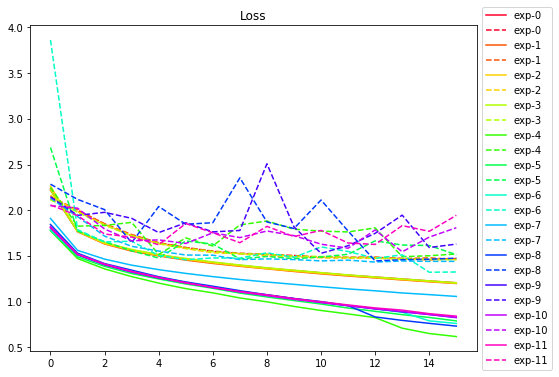

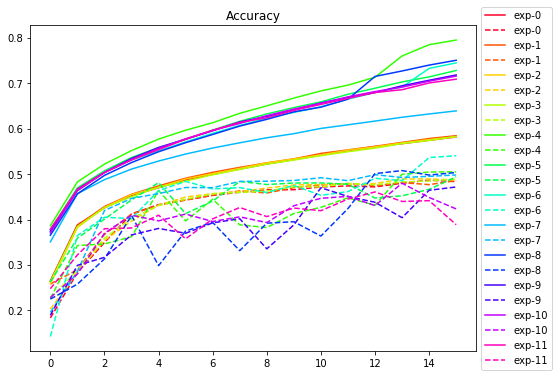

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()